In [1]:
%matplotlib inline
import numpy as np
import poisson_tools as pt
import matplotlib.pyplot as plt
from scipy.special import expit

In [2]:
train_x, train_y = pt.get_train_data()
train_x = train_x > 50

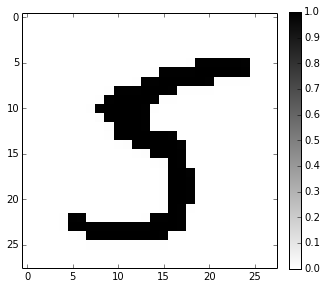

In [3]:
pt.plot_digit(train_x[59997])
plt.savefig('test.pdf')

In [4]:
digit = 5
label_list = np.array(train_y).astype(int)
index_digit = np.where(label_list==digit)[0]
train_num = len(index_digit)-1
index_train = index_digit[0:train_num]
Data_v = np.array(train_x[index_train]).astype(float)

# Given V0, get (v0, h0) and (v1, h1)

In [6]:
def sigmoid_sampling(data, weight, bias):
    sum_data = np.dot(data, weight) + bias
    prob = expit(sum_data)
    rdm = np.random.random(prob.shape)
    index_on = rdm < prob
    samples = np.zeros(prob.shape)
    samples[index_on]=1.
    return samples
    

In [7]:
def update_para(v0, h0, v1, h1, a, b, w, eta ):
    delta_a = np.zeros(v0.shape)
    delta_b = np.zeros(h0.shape)
    delta_w = np.zeros(w.shape)
    batch_size = v0.shape[0]
    
    delta_a = eta * (v0 - v1)
    delta_b = eta * (h0 - h1)
    for k in range(batch_size):
        v0_matrix = np.transpose(np.tile(v0[k],(w.shape[1],1)))
        v1_matrix = np.transpose(np.tile(v1[k],(w.shape[1],1)))
        h0_matrix = np.tile(h0[k],(w.shape[0],1))
        h1_matrix = np.tile(h1[k],(w.shape[0],1))
        delta_w += eta * (v0_matrix*h0_matrix - v1_matrix*h1_matrix)
    
    a += np.average(delta_a,0)
    b += np.average(delta_b,0)
    w += delta_w/np.float(batch_size)
    return a, b, w

In [8]:
def sampling_k(a, b, w, sample_num, init_v):
    gibbs_v = np.zeros((sample_num, a.shape[0]))
    gibbs_h = np.zeros((sample_num, b.shape[0]))
    gibbs_v[0] = init_v
    for g_step in range(1, sample_num):
        gibbs_h[g_step-1] = sigmoid_sampling(gibbs_v[g_step-1], w, b)
        gibbs_v[g_step] = sigmoid_sampling(gibbs_h[g_step-1], w.transpose(), a)
    gibbs_h[-1] = sigmoid_sampling(gibbs_v[-2], w, b)
    return gibbs_v, gibbs_h

In [9]:
def matrix_times(m, n):
    m_matrix = np.transpose(np.tile(m,(len(n), 1)))
    n_matrix = np.tile(n,(len(m), 1))
    return m_matrix*n_matrix

In [13]:
def update_cdk(a, b, w, data_v, cd_size):
    max_bsize = data_v.shape[0]
    ind_rdm = int(np.floor(np.random.random()*max_bsize))
    init_v = data_v[ind_rdm]
    gibbs_v, gibbs_h = sampling_k(a, b, w, cd_size, init_v)
    avg_h = []
    for vd in range(max_bsize):
        data_h = np.zeros((cd_size, b.shape[0]))
        for h in range(cd_size):
            data_h[h] = sigmoid_sampling(data_v[vd], w, b)
        avg_h.append(np.average(data_h, axis=0))
    
    
    delta_a = eta * (np.average(data_v,0) - np.average(gibbs_v,0))
    delta_b = eta * (np.average(avg_h,0) - np.average(gibbs_h,0))
    pos_delta_w = np.zeros(w.shape)
    neg_delta_w = np.zeros(w.shape)
    for vd in range(max_bsize):
        pos_delta_w += matrix_times(data_v[vd], avg_h[vd])
    for gstep in range(cd_size):
        neg_delta_w += matrix_times(gibbs_v[gstep], gibbs_h[gstep])    
    a += delta_a
    b += delta_b
    w += eta * pos_delta_w/np.float(max_bsize)
    w -= eta * neg_delta_w/np.float(cd_size)
    return a, b, w

# Initialisation of W, a and b

In [21]:
hiden_num = 500
W = np.random.normal(0,0.01,Data_v.shape[1]*hiden_num)
W = W.reshape((Data_v.shape[1],hiden_num))
b = np.zeros(hiden_num)
pixel_on = np.sum(Data_v,0)
a = np.log((pixel_on + 0.01)/(train_num - pixel_on + 0.01))
eta = 0.001

In [18]:
batch_size = 1000
for iteration in range(1):
    for k in range(0,train_num,batch_size):
        max_bsize = min(train_num-k, batch_size)
        data_v = Data_v[k:k+max_bsize]
        a, b, W = update_cdk(a, b, W, data_v, batch_size)
        print iteration+1, k

1 0
1 1000
1 2000
1 3000
1 4000
1 5000


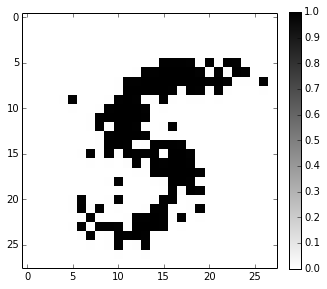

In [24]:
np.random.seed(0)
data_v = np.array(train_x[index_digit[train_num]]).astype(float)
data_h = sigmoid_sampling(data_v, W, b)
recon = sigmoid_sampling(data_h, W.transpose(), a)
pt.plot_digit(recon)

In [23]:
batch_size = 1
for iteration in range(1):
    for k in range(0,train_num,batch_size):
        data_v = Data_v[k:k+batch_size]
        data_h = sigmoid_sampling(data_v, W, b)
        gibbs_v = sigmoid_sampling(data_h, W.transpose(), a)
        gibbs_h = sigmoid_sampling(gibbs_v, W, b)
        a, b, W = update_para(data_v, data_h, gibbs_v, gibbs_h, a, b, W, eta)